In [7]:

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
import os, sys, random
import pickle as pkl
from os.path import exists, join

sys.path.append('../dependencies/')

# Figure dir
figDir = os.path.join(os.getcwd(), 'figures_output')
if not os.path.isdir(figDir):
    os.makedirs(figDir)

# Define the target directory
targDir = "C:\OneDrive\KwanLab\Lightsheet_cFos_Pipeline\\1.scaled_Output\\classif"

# Define a list of substrings to filter directories
tagList = ['data=count_norm-', 'PowerTrans_RobScal_fSel_BorFS_clf_LogReg(multinom)_CV100']

# Call the function and get the list of paths based on the tagList
score_dict_paths = []

# Walk through the directory and its subdirectories
for root, dirs, files in os.walk(targDir):
    # Check if 'scoreDict.pkl' is present in the files
    if 'scoreDict_Real.pkl' in files:
        if all(tag in root for tag in tagList):
            score_dict_paths.append(os.path.join(root, 'scoreDict_Real.pkl'))

# Each directory name will be used to generate a label, based on the sequence between the strings in the directory name below
startStr = 'count_norm-'
endStr = '\PowerTrans'
featureLists, countNames  = [], []

# Print the result
print(f"Found 'scoreDict.pkl' files in directories containing {tagList}:")
for path in score_dict_paths:

    # Load the scoreDict.pkl file and extract desired variables.
    with open(path, 'rb') as f:                 
        featureDict = pkl.load(f)
        featureLists.append(featureDict['featuresPerModel'])

    # Extract the label for the entry
    countNames.append(featureDict['compLabel'])

Found 'scoreDict.pkl' files in directories containing ['data=count_norm-', 'PowerTrans_RobScal_fSel_BorFS_clf_LogReg(multinom)_CV100']:


## Create Violin Plot for Feature counts

In [8]:
# Set Style of Font
import matplotlib.pyplot as plt
# Set font to 12 pt Helvetica
plt.rcParams['font.family'] = 'Helvetica'
plt.rcParams['font.size'] = 8
plt.rcParams['svg.fonttype'] = 'none'

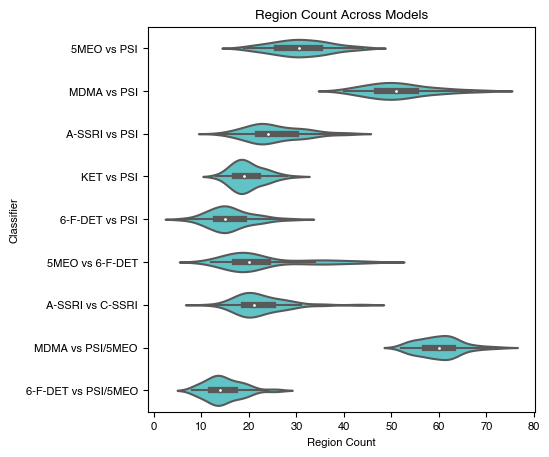

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

colorsList = [[82, 211, 216], [56, 135, 190]]
colorsList = np.array(colorsList)/256

origNames = ['5MEO vs PSI', 'MDMA vs PSI', 'A-SSRI vs PSI', 'KET vs PSI', '6-F-DET vs PSI', '5MEO vs 6-F-DET', 'A-SSRI vs C-SSRI', 'MDMA vs PSI/5MEO', '6-F-DET vs PSI/5MEO']
scoreNames = countNames

# Your list of lists (sublists with numbers)
data = [[len(sublist) for sublist in inner_list] for inner_list in featureLists]

# Use numpy.argsort to obtain the indices that would sort the original list
sort_indices = [scoreNames.index(name) for name in origNames]

# Use the sorted indices to reorder the original list
names = np.array(scoreNames)[sort_indices]
data = np.array(data)[sort_indices]

# If swapping names is desired
# swapDict = dict()
# swapDict['MDMA vs PSI/5MEO'] = 'PSI/5MEO vs MDMA'
# swapDict['6-F-DET vs PSI/5MEO'] = 'PSI/5MEO vs 6-F-DET'

# for i in range(len(names)):
#     if names[i] in swapDict:
#         names[i] = swapDict[names[i]]

# Create a data frame with melted data
flat_data = [item for sublist in data for item in sublist]

df = pd.melt(pd.DataFrame(data, index=names).T, var_name='Category', value_name='Values')

# Create horizontally oriented violin plot
plt.figure(figsize=(5, 5))  # Adjust the width and height as needed

ax = sns.violinplot(x='Values', y='Category', bw_adjust=.5, data=df, orient='h', color=colorsList[0])  #, palette=colors)  # Remove inner bars and set color
# for violin in ax.collections:
#     violin.set_alpha(1)

# Set plot labels and title
plt.xlabel('Region Count')
plt.ylabel('Classifier')
plt.title('Region Count Across Models')

plt.savefig(f"{figDir}\\RegionCountPerSplit_violin.svg", format='svg', bbox_inches='tight')     

# Show the plot
plt.show()

# Create Distance matricies to compare features across comparisons

In [10]:
from collections import Counter

def weighted_jaccard_similarity(u, v, filt):

    counter_u, counter_v = Counter(u), Counter(v)

    # If Filt is non-0, filter out features in each counter whose count is not above it.
    if filt:
        counter_u = Counter({k: v for k, v in counter_u.items() if v > filt})
        counter_v = Counter({k: v for k, v in counter_v.items() if v > filt})

    intersection = sum((counter_u & counter_v).values())
    union = sum((counter_u | counter_v).values())

    # Using the modified Jaccard similarity with frequency
    similarity = intersection / union if union != 0 else 0

    return similarity

modelCount = len(featureLists)
# regionDict = dict(Counter(featureLists[0]))
# labels, counts = list(regionDict.keys()), list(regionDict.values())

# Initialize a grid
grid = [[0 for _ in range(modelCount)] for _ in range(modelCount)]

# Flatten every list
featureListFlat = [[element for item in subList for element in item] for subList in featureLists]

weightedList = True
# compare the mean distances across items of the list
for idx_a, listA in enumerate(featureListFlat):
    for idx_b, listB in enumerate(featureListFlat):
        grid[idx_a][idx_b] = weighted_jaccard_similarity(listA, listB, 75)

## Plot

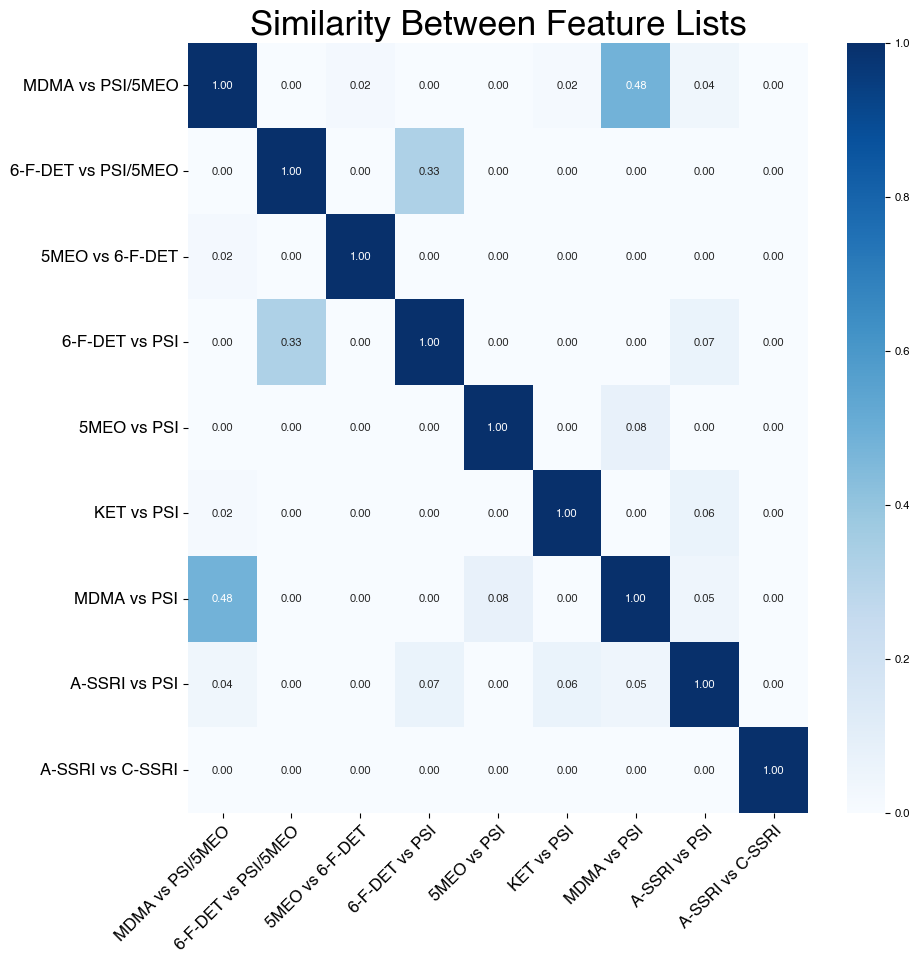

In [11]:
from matplotlib import cm

# Plot the grid
fig, ax = plt.subplots(figsize=(10,10))
# plt.figure(figsize=(10,10)) cm.plasma.reversed()
# im = ax.imshow(grid, cmap='Blues', interpolation='nearest')
im = sns.heatmap(grid, cmap='Blues', annot=True, fmt='.2f', ax=ax, yticklabels=scoreNames, xticklabels=scoreNames)
# cbar = plt.colorbar(im, shrink=0.8)
# cbar.ax.tick_params(labelsize=15)  # Adjust the font size for colorbar ticks

# Set font size for x-axis ticks and labels
ax.tick_params(axis='x', labelsize=12)

# Set font size for y-axis ticks and labels
ax.tick_params(axis='y', labelsize=12)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
# plt.yticks(range(modelCount)+0.5, scoreNames, rotation=0)
plt.title('Similarity Between Feature Lists', fontdict={'fontsize': 25})
plt.savefig(f"{figDir}\\MeanSimilarity_heatmap.svg", format='svg', bbox_inches='tight')     
plt.show()


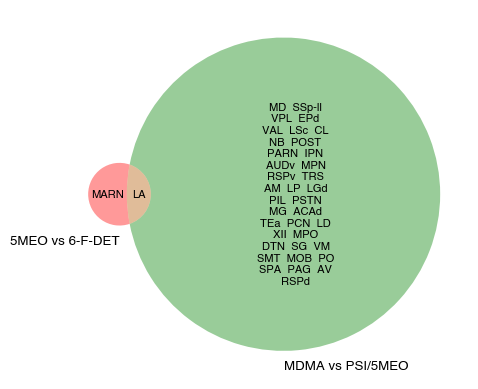

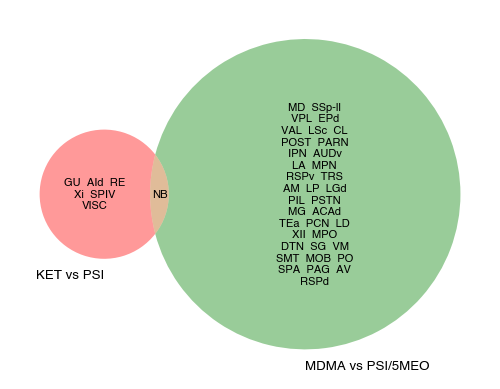

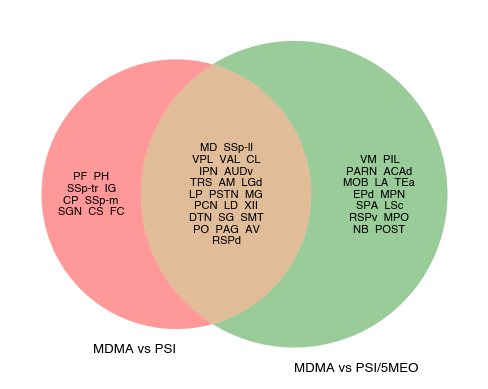

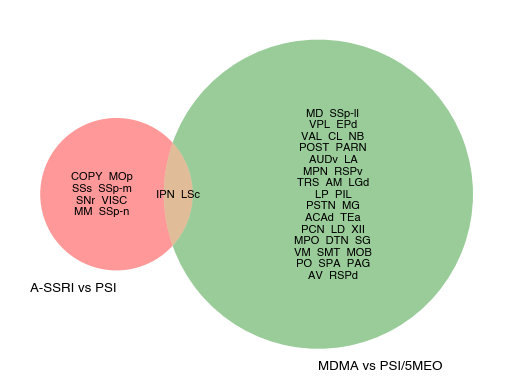

In [13]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import textwrap

wrapper = textwrap.TextWrapper(width=12, break_on_hyphens=False)  # Adjust width as needed


# Sample data
for idx1, list1 in enumerate(featureListFlat):
    for idx2, list2 in enumerate(featureListFlat):

        if idx1 == idx2:
            continue

        counter_u, counter_v = Counter(list1), Counter(list2)

        counter_u = Counter({k: v for k, v in counter_u.items() if v >= 75})
        counter_v = Counter({k: v for k, v in counter_v.items() if v >= 75})

        list1 = list(counter_u.keys())
        list2 = list(counter_v.keys())
        only_list1 = list(set(list1) - set(list2))
        only_list2 = list(set(list2) - set(list1))
        intersection = list(set(list1) & set(list2))

        if intersection == []:
            continue

        # Create a Venn diagram
        venn_diagram = venn2(subsets=(len(only_list1), len(only_list2), len(intersection)/2),
                            set_labels=(scoreNames[idx1], scoreNames[idx2]))


        venn_labels = {'100': only_list1, '010': only_list2, '110': intersection}
        for idx, (labId, labels) in enumerate(venn_labels.items()):
            wrapped_labels = wrapper.fill(text='  '.join(labels))
            venn_diagram.get_label_by_id(labId).set_text(wrapped_labels)
            venn_diagram.get_label_by_id(labId).set_fontsize(8)  # Adjust font size if needed

        # # Customize the size of the Venn diagram
        # plt.gcf().set_size_inches(8, 8)
        figName = f'VD_{scoreNames[idx1]} and {scoreNames[idx2]}'
        figName = figName.replace('/', '+')
        figName = figName.replace(' ', '_')
        plt.savefig(f"{figDir}\\{figName}.svg", format='svg', bbox_inches='tight')     

        # Display the plot
        plt.show()